In [5]:
# BERT Embeddings + Visualization
# The vector for a word depends on the sentence it appears in.
# “bank of the river” → bank = river side
# “bank approved the loan” → bank = financial institution
# 👉 Word2Vec gives one vector per word
# 👉 BERT gives one vector per word per context
# | Feature            | Word2Vec / FastText | BERT            |
# | ------------------ | ------------------- | --------------- |
# | Embedding type     | Static              | Contextual      |
# | Polysemy handling  | ❌ No               | ✅ Yes          |
# | Architecture       | Shallow NN          | Transformer     |
# | Training objective | Context prediction  | Masked LM + NSP |
# | Dimensionality     | 50–300              | 768 (base)      |
# | Used in modern NLP | ❌ Rare             | ✅ Standard     |

# BERT embeddings capture syntax + semantics + context.
# 2. Next-Gen Architectures Going Beyond Classic Transformers
# 🔹 Titans (Google’s Proposed Successor to Transformers)

In [6]:
import torch
from transformers import BertTokenizer, BertModel

In [8]:
tokenizer = BertTokenizer.from_pretrained("/media/scientist-anand/volume/mr_document/all_models/bert-based-uncased")
model = BertModel.from_pretrained("/media/scientist-anand/volume/mr_document/all_models/bert-based-uncased")

In [ ]:
sentences = [
    "I love this product",
    "This product is amazing",
    "I hate this service",
    "This is the worst experience"
]
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Sentence 1: [101, 7592, 2088, 102]
# Sentence 2: [101, 2023, 2003, 1037, 7953, 102]

# After padding:
# [
#  [101, 7592, 2088, 102,   0,   0],
#  [101, 2023, 2003, 1037, 7953, 102]
# ]
# 1 = real token
# 0 = padding token

# Tells PyTorch:

# torch.no_grad() “I’m not training, just doing inference”
# Effects
# No gradients are stored
# No computation graph is built
# Faster execution
# Much lower memory usage
# When to use

# Evaluation
# Embedding extraction
# Inference / prediction

# Keeps only the first 512 tokens
# Deletes the rest permanently
# If every detail matters, then simple truncation is NOT acceptable. You must process long text in pieces and then combine the information.
# Yes — this is a neural-network architecture limitation, not an arbitrary tokenizer rule.
# O(n²)
# 512² = 262,144 attention interactions

inputs = tokenizer(
    sentences,
    padding=True,
    truncation=True, # Max Length 512 if it is more than that it will remove or truncate to 512 if its 600
    return_tensors="pt"
)
with torch.no_grad(): # “I’m not training, just doing inference”
    outputs = model(**inputs)

token_embeddings = outputs.last_hidden_state

In [18]:
# | Model       | Trick                             |
# | ----------- | --------------------------------- |
# | Longformer  | Sparse attention                  |
# | BigBird     | Block + random attention          |
# | RoPE models | Mathematical position encoding    |
# | ALiBi       | Linear bias instead of embeddings |

# [CLS] = Classification token
# It is a special token added at the beginning of the input.

# [CLS] is used for Next Sentence Prediction (NSP)
# [SEP] = Separator token

# End of a sentence
# Boundary between two sentences

# [CLS] This is a sentence [SEP]
# I love machine learning. It is very powerful.
# [CLS] I love machine learning . [SEP] It is very powerful . [SEP]
# ========================================================================= #
# (batch_size, seq_len, hidden_size)
# | Dimension   | Meaning                                                       |
# | ----------- | ------------------------------------------------------------- |
# | batch_size  | Number of sentences or sequences in the batch (`n_sentences`) |
# | seq_len     | Number of tokens in each sentence (after padding/truncation)  |
# | hidden_size | Size of the model’s hidden layer (BERT-base: 768)             |

# Why [:, 0, :]?

# : → select all sentences in the batch
# 0 → select token at position 0 → this is [CLS]
# : → select all hidden dimensions (full embedding vector)

# token_embeddings (batch_size, seq_len, hidden_size)
# ╔═════════════╗
# ║ [CLS] token ║ ← position 0 → vector for entire sentence
# ║ token 1     ║
# ║ token 2     ║
# ║ ...         ║
# ║ [SEP] token ║ ← last token
# ╚═════════════╝

# "with" A context manager handles setup and cleanup automatically.


In [ ]:
# inputs["attention_mask"] is automatically generated by the tokenizer.
# It’s a tensor of 1s and 0s indicating real tokens vs padding.
# It is passed to the model alongside input_ids for correct attention computation.
    
token_embeddings.shape  # (batch_size, seq_len, hidden_size)

torch.Size([4, 7, 768])

In [19]:
# attention_mask = tensor([
#   [1, 1, 1, 1, 0, 0],
#   [1, 1, 1, 1, 1, 0]
# ])
# unsqueeze(-1)
# attention_mask.unsqueeze(-1) adds a new dimension at the last position:
# attention_mask.unsqueeze(-1).shape  # (batch_size, seq_len, 1)
# Why? Because we want to match the shape of token_embeddings along the embedding dimension so we can multiply or mask them elementwise.
# [[[1], [1], [1], [1], [0], [0]],
#  [[1], [1], [1], [1], [1], [0]]]

# expand(token_embeddings.size())
# .expand() repeats the tensor along the new dimensions without copying memory, making it the same shape as token_embeddings:
# mask.shape  # (batch_size, seq_len, embedding_dim)


In [ ]:
# Mean pooling (better in practice) 
# Mean pooling often performs better than raw [CLS].

attention_mask = inputs["attention_mask"]
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1]])

In [26]:
print(attention_mask.shape)
mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()) ## Adding to make it the same size as token embeddings -1 means at end
print(mask.shape)
masked_embeddings = token_embeddings * mask
print(masked_embeddings.shape)

torch.Size([4, 7])
torch.Size([4, 7, 768])
torch.Size([4, 7, 768])


In [ ]:
# Dimensionality Reduction for Visualization PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sentence_embeddings)

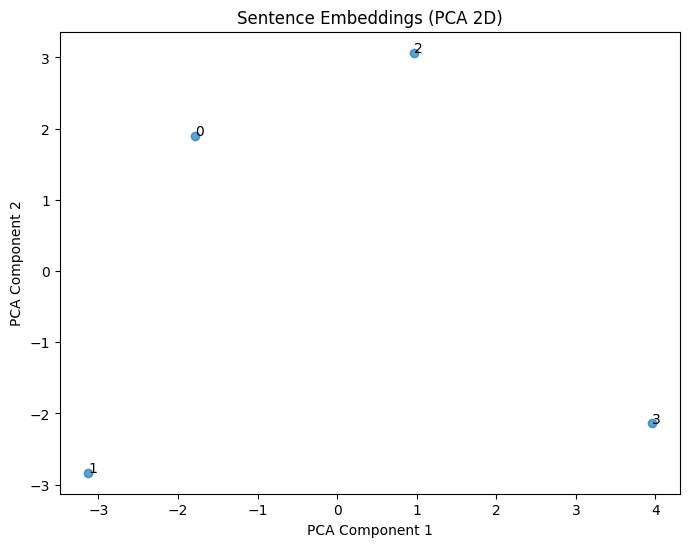

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

# Optional: annotate each point with sentence index
for i, txt in enumerate(range(len(embeddings_2d))):
    plt.annotate(i, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Sentence Embeddings (PCA 2D)")
plt.show()